In [42]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
from IPython import display
import json

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

from src.utils.wandb_helpers import get_runs
from src.utils.plotting import plot_se

from functools import partial
api = wandb.Api()
get_runs = partial(get_runs, api=api)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [38]:
def group_f(df):
    res = {}
    for col in df:
        if df[col].dtype == 'object':
            res[col] = df[col].iloc[0]
        else:
            res[col] = df[col].mean()
    return pd.Series(res)

# Architectures

In [43]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'
for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in ['0xa8ddeefc', '0xfd90d18c'] and run['config'].get('seed', 0) == 0:
        print(json.dumps(run['config']['model'], indent=4))

{
    "beta": 2,
    "type": "unsupervised",
    "model": "VAE_deep",
    "input_dim": [
        3,
        7680
    ],
    "n_classes": 3,
    "latent_dim": 30720,
    "latent_std": 1,
    "n_channels": 3,
    "loss_reduction": "mean",
    "model_description": "60 s, beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid",
    "first_decoder_conv_depth": 32
}
{
    "type": "unsupervised",
    "model": "AE_parametrized",
    "decoder": {
        "in_conv_config": {
            "n_convs": 2,
            "activation": "Sigmoid",
            "in_channels": 24,
            "kernel_size": 3,
            "out_channels": 24
        },
        "up_blocks_config": [
            {
                "n_convs": 2,
                "activation": "Sigmoid",
                "in_channels": 24,
                "kernel_size": 3,
                "out_channels": 12
            },
            {
                "n_convs": 2,
                "activation": "Sigmoid",
                "in_channels": 12,
            

# Augmentations

In [39]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    # print(run['config']['hash'], run['config']['run_hash'], run['config']['run_name'])
    if run['config'].get('hash', 0) in [
        '0xffaec9a3', #without retrain
        '0xa0842ebf',
        '0x61a7b125',
        '0xd7a48de2',
        '0x33fefd40',#with retrain
        '0xe71dbcc8',
        '0xd29f5f52',
        '0xbfab3d83',
        '0xfd90d18c', #baseline bVAE
        '0xa8ddeefc' #baseline AE
    ]:
        # print(run['config']['run_hash'], run['summary'].keys())
        results.append({
            "run_hash": run['config']['run_hash'],
            "pretrain": run['config']['dataset']['train']['pretrain'] is not None,
            "augmentation": "10-% step" if '10-pct' in run['config']['run_name'] else "no augmentations",
            "ml_model_was_retrained": run['config']['ml'].get("ml_to_train", True),
            "model": run['config']['model']['model'],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            "balanced_accuracy": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],
            "balanced_accuracy_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se']
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['model', 'augmentation', 'ml_model_was_retrained', 'pretrain'])
results

,pretrain,augmentation,ml_model_was_retrained,model,average_precision,average_precision_se,balanced_accuracy,balanced_accuracy_se
run_hash,,,,,,,,
0ad7c867f484f2a5,0.000,10-% step,0.000,AE_parametrized,0.871,0.076,0.827,0.091
81febd4b82482e93,1.000,10-% step,0.000,AE_parametrized,0.769,0.061,0.732,0.059
88fb1d2406a608e3,0.000,10-% step,1.000,AE_parametrized,0.892,0.069,0.797,0.091
d7ffbb0de4dfb615,1.000,10-% step,1.000,AE_parametrized,0.872,0.072,0.721,0.084
6e12d1cb8b70e613,1.000,no augmentations,1.000,AE_parametrized,0.600,0.181,0.482,0.235
1ecc1b617542d054,0.000,10-% step,0.000,VAE_deep,0.524,0.000,0.500,0.000
9520129a0c0f55a1,1.000,10-% step,0.000,VAE_deep,0.807,0.043,0.749,0.045
481c3efa132fb053,0.000,10-% step,1.000,VAE_deep,0.933,0.058,0.895,0.067
094355a48da7d66d,1.000,10-% step,1.000,VAE_deep,0.936,0.054,0.865,0.077


# honke_higgins_2010_15274

## AE

In [25]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    # print(run['config']['hash'], run['config']['run_hash'], run['config']['run_name'])
    if run['config'].get('hash', 0) in [
        '0x9a3ba1cc', #without pretrain,
        '0x28bfaafb' #with pretrain
    ]:
        # print(run['config']['run_hash'], run['summary'].keys())
        results.append({
            "run_hash": run['config']['run_hash'],
            "pretrain": run['config']['dataset']['train']['pretrain'] is not None,

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            "balanced_accuracy": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],
            "balanced_accuracy_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se']
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['pretrain'])
results

,pretrain,average_precision,average_precision_se,balanced_accuracy,balanced_accuracy_se
run_hash,,,,,
036e5bbb3b5a94c9,0.0,0.504769,0.033602,0.498726,0.002024
67e6a918a04dbbe7,1.0,0.484837,0.031151,0.496581,0.006033


## bVAE

In [27]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    # print(run['config']['hash'], run['config']['run_hash'], run['config']['run_name'])
    if run['config'].get('hash', 0) in [
        '0x66c69cf5', #without pretrain,
        '0x371123f4', #with pretrain,
        '0x72e13096' #with 10-% step augmentation
    ]:
        # print(run['config']['run_hash'], run['summary'].keys())
        results.append({
            "run_hash": run['config']['run_hash'],
            "pretrain": run['config']['dataset']['train']['pretrain'] is not None,
            "beta": run['config']['model']['framework']['beta'],
            "augmentation": '10%-step' if '10-pct' in run['config']['run_name'] else "no augmentations",

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            "balanced_accuracy": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],
            "balanced_accuracy_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se']
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['augmentation', 'pretrain', 'beta'])
results

,pretrain,beta,augmentation,average_precision,average_precision_se,balanced_accuracy,balanced_accuracy_se
run_hash,,,,,,,
c4632bebb311c68c,0.0,2.000,10%-step,0.492761,0.009753,0.502867,0.003882
af5d3e243f8080be,0.0,0.075,no augmentations,0.506759,0.034045,0.500000,0.000000
9f5c5a1acaf271a5,0.0,0.100,no augmentations,0.520520,0.033202,0.501095,0.001512
23867c71aaf72d80,0.0,0.500,no augmentations,0.498318,0.033928,0.500000,0.000000
2399d1a8ec49cac1,0.0,1.000,no augmentations,0.498318,0.033928,0.500000,0.000000
e0ad775864a15afe,0.0,1.500,no augmentations,0.498318,0.033928,0.500000,0.000000
055fbed6ed90d7ca,0.0,2.000,no augmentations,0.498318,0.033928,0.500000,0.000000
e7d34a814dfd0b88,1.0,0.075,no augmentations,0.470359,0.029115,0.500145,0.001096
f06ed20aa9f9f82f,1.0,1.000,no augmentations,0.473824,0.029356,0.500145,0.001096


# ellis_sattiraju_2023_10385424

In [5]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) == '0x51e1953c' or \
    (run['config'].get('hash', 0) == '0' and run['config'].get('run_hash', 0) in ['32c92d044ec30a90']): #with 10-% step augmentation and without any augmentations
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            "augmentation": '10-% step' if run['config']['hash'] == '0x51e1953c' else 'no augmentations',

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            "balanced_accuracy": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],
            "balanced_accuracy_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se']
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['augmentation'])

results.set_index('augmentation', inplace=True)
results

,average_precision,average_precision_se,balanced_accuracy,balanced_accuracy_se
augmentation,,,,
10-% step,0.561485,0.067112,0.524324,0.053216
no augmentations,0.673894,0.141848,0.517804,0.071457


# Channels perturbation (AE, 3 ch., 6/12/24/24, 7/7/5/3/3/3/3/1, Sigmoid and beta-VAE, 3 ch., 4/8/16/32, 7/7/5/3/3/3/3/1, Sigmoid)

## AE

### Finetune

In [40]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0xf1f9af5d', #normal
        '0xfad4f544', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],#['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se'],#['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,1.0,0.494288,0.164021,16.212783,0.000000,0.231961
cz,1.0,0.500000,0.000000,16.381781,0.005712,0.164021
fz,1.0,0.466534,0.094234,17.099961,-0.027754,0.189164
pz,1.0,0.500000,0.000000,17.812543,0.005712,0.164021


In [41]:
pretrain_x = results.index[1:]
pretrain_y = results['average_precision_diff'][1:]*100
pretrain_yerr = results['average_precision_diff_se'][1:]*100

### Train

In [42]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0x9596108d', #normal
        '0xd027eb95', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],#['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se'],#['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,0.0,0.502738,0.160804,13.701400,0.000000,0.227411
cz,0.0,0.500000,0.000000,13.841419,-0.002738,0.160804
fz,0.0,0.500000,0.000000,13.553395,-0.002738,0.160804
pz,0.0,0.547835,0.046716,13.599563,0.045097,0.167453


In [43]:
train_x = results.index[1:]
train_y = results['average_precision_diff'][1:]*100
train_yerr = results['average_precision_diff_se'][1:]*100

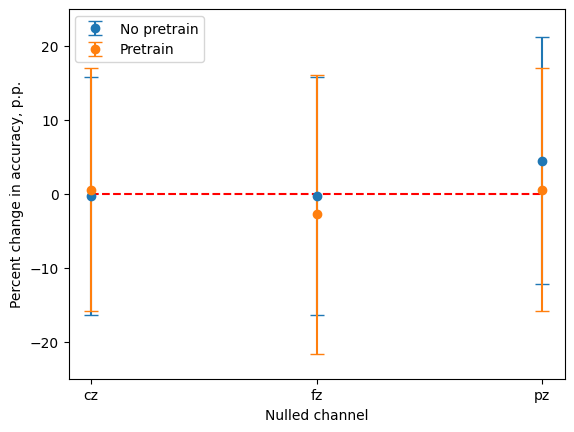

In [44]:
plt.errorbar(train_x, train_y, yerr=train_yerr, fmt='o', capsize=5, label="No pretrain")
plt.errorbar(pretrain_x, pretrain_y, yerr=pretrain_yerr, fmt='o', capsize=5, label="Pretrain")
plt.hlines(0, xmin=train_x[0], xmax=train_x[-1], colors="r", linestyles="dashed")
plt.ylabel("Percent change in accuracy, p.p.")
plt.xlabel("Nulled channel")
plt.ylim((-25, 25))
plt.legend()

### Finetune

In [53]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0xf1f9af5d', #normal
        '0xfad4f544', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,1.0,0.578667,0.152283,16.212783,0.000000,0.215361
cz,1.0,0.482529,0.125513,16.381781,-0.096138,0.197342
fz,1.0,0.514856,0.146605,17.099961,-0.063810,0.211384
pz,1.0,0.529978,0.129639,17.812543,-0.048689,0.199992


In [54]:
pretrain_x = results.index[1:]
pretrain_y = results['average_precision_diff'][1:]*100
pretrain_yerr = results['average_precision_diff_se'][1:]*100

### Train

In [55]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0x9596108d', #normal
        '0xd027eb95', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,0.0,0.600274,0.153156,13.701400,0.000000,0.216595
cz,0.0,0.533442,0.151808,13.841419,-0.066832,0.215644
fz,0.0,0.573252,0.153816,13.553395,-0.027022,0.217062
pz,0.0,0.546049,0.138708,13.599563,-0.054225,0.206631


In [56]:
train_x = results.index[1:]
train_y = results['average_precision_diff'][1:]*100
train_yerr = results['average_precision_diff_se'][1:]*100

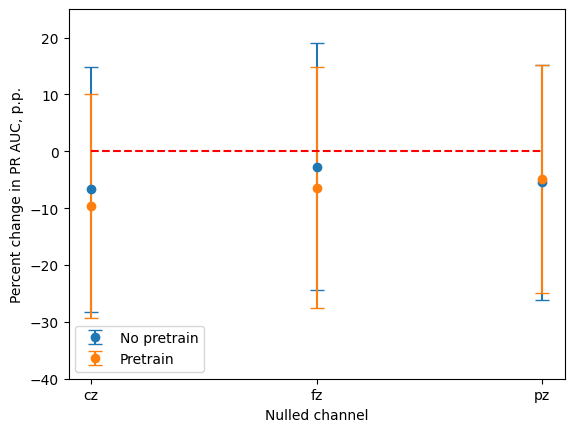

In [58]:
plt.errorbar(train_x, train_y, yerr=train_yerr, fmt='o', capsize=5, label="No pretrain")
plt.errorbar(pretrain_x, pretrain_y, yerr=pretrain_yerr, fmt='o', capsize=5, label="Pretrain")
plt.hlines(0, xmin=train_x[0], xmax=train_x[-1], colors="r", linestyles="dashed")
plt.ylabel("Percent change in PR AUC, p.p.")
plt.xlabel("Nulled channel")
plt.ylim((-40, 25))
plt.legend()

## bVAE

### Finetune

In [35]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0xf3c49a3d', #normal
        '0xe1abf356', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],#['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se'],#['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,1.0,0.481373,0.075768,14.867526,0.000000,0.107152
cz,1.0,0.500000,0.000000,17.548952,0.018627,0.075768
fz,1.0,0.500000,0.000000,17.553349,0.018627,0.075768
pz,1.0,0.501412,0.055403,17.624750,0.020039,0.093863


In [36]:
pretrain_x = results.index[1:]
pretrain_y = results['average_precision_diff'][1:]*100
pretrain_yerr = results['average_precision_diff_se'][1:]*100

### Train

In [37]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0x29ca1994', #normal
        '0x5bf99f57', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],#['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se'],#['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,0.0,0.584111,0.155776,2.155128,0.000000,0.220301
cz,0.0,0.500000,0.000000,1.987898,-0.084111,0.155776
fz,0.0,0.499882,0.025808,2.001589,-0.084229,0.157899
pz,0.0,0.500000,0.000000,3.964361,-0.084111,0.155776


In [38]:
train_x = results.index[1:]
train_y = results['average_precision_diff'][1:]*100
train_yerr = results['average_precision_diff_se'][1:]*100

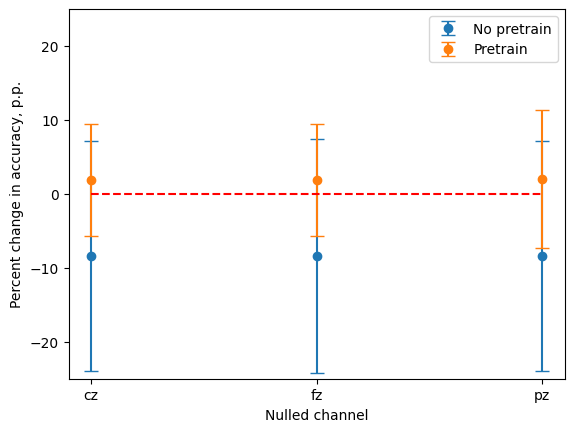

In [39]:
plt.errorbar(train_x, train_y, yerr=train_yerr, fmt='o', capsize=5, label="No pretrain")
plt.errorbar(pretrain_x, pretrain_y, yerr=pretrain_yerr, fmt='o', capsize=5, label="Pretrain")
plt.hlines(0, xmin=train_x[0], xmax=train_x[-1], colors="r", linestyles="dashed")
plt.ylabel("Percent change in accuracy, p.p.")
plt.xlabel("Nulled channel")
plt.ylim((-25, 25))
plt.legend()

### Finetune

In [45]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0xf3c49a3d', #normal
        '0xe1abf356', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,1.0,0.526132,1.024461e-01,14.867526,0.000000,0.144881
cz,1.0,0.494949,1.450665e-16,17.548952,-0.031182,0.102446
fz,1.0,0.494949,1.450665e-16,17.553349,-0.031182,0.102446
pz,1.0,0.542302,5.293911e-02,17.624750,0.016170,0.115316


In [46]:
pretrain_x = results.index[1:]
pretrain_y = results['average_precision_diff'][1:]*100
pretrain_yerr = results['average_precision_diff_se'][1:]*100

### Train

In [47]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0x29ca1994', #normal
        '0x5bf99f57', #with zero out different channels
    ]:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            'pretrain': True if 'finetune' in description else False,
            'zeroed_out_channel': run['config']['run_name'].split(",")[0].split(" ")[-1],

            "average_precision": run['summary'][model_type]['clf.d.test.bs.average_precision'],
            "average_precision_se": run['summary'][model_type]['clf.d.test.bs.average_precision.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['zeroed_out_channel'])

results.set_index('zeroed_out_channel', inplace=True)
baseline = results.loc["None"]["average_precision"]
baseline_se = results.loc["None"]["average_precision_se"]
results["average_precision_diff"] = results["average_precision"] - baseline
results["average_precision_diff_se"] = np.sqrt(results["average_precision_se"]**2 + baseline_se**2)
results

,pretrain,average_precision,average_precision_se,snr_db,average_precision_diff,average_precision_diff_se
zeroed_out_channel,,,,,,
None,0.0,0.707941,1.597156e-01,2.155128,0.000000,0.225872
cz,0.0,0.494949,1.450665e-16,1.987898,-0.212991,0.159716
fz,0.0,0.529842,5.728342e-02,2.001589,-0.178099,0.169678
pz,0.0,0.494949,1.450665e-16,3.964361,-0.212991,0.159716


In [48]:
train_x = results.index[1:]
train_y = results['average_precision_diff'][1:]*100
train_yerr = results['average_precision_diff_se'][1:]*100

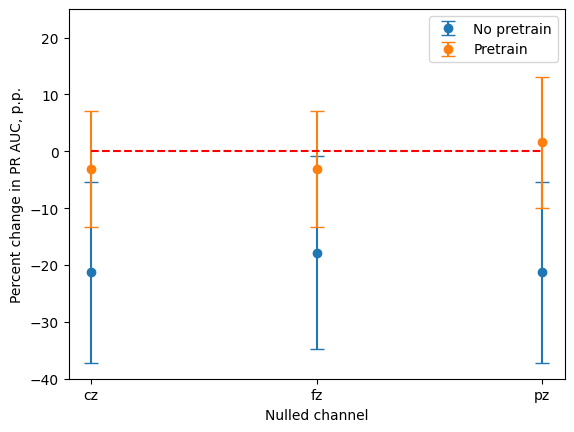

In [52]:
plt.errorbar(train_x, train_y, yerr=train_yerr, fmt='o', capsize=5, label="No pretrain")
plt.errorbar(pretrain_x, pretrain_y, yerr=pretrain_yerr, fmt='o', capsize=5, label="Pretrain")
plt.hlines(0, xmin=train_x[0], xmax=train_x[-1], colors="r", linestyles="dashed")
plt.ylabel("Percent change in PR AUC, p.p.")
plt.xlabel("Nulled channel")
plt.ylim((-40, 25))
plt.legend()

# 10-pct overlap

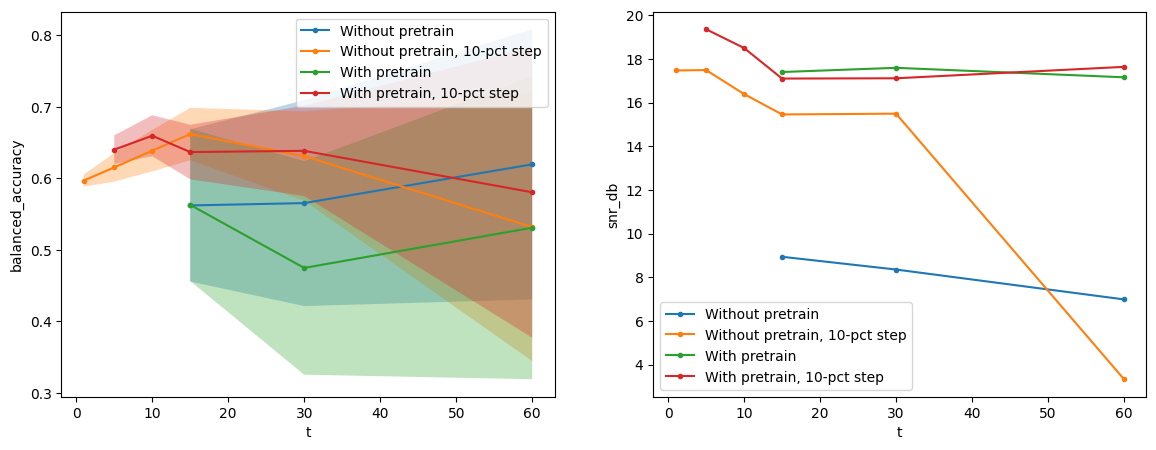

In [4]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0x868e5655', #with 10-pct sliding window
        '0x78c6d3bd', #with 10-pct sliding window
        '0x1168f9c', #without 10-pct sliding window
        '0x321f7672', #without 10-pct sliding window
    ] and run['config'].get('run_hash', 0) not in ['9c89bb02d501c7a2']:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            "t": run['config']['dataset']['samples_shape'][1]/128,
            'time_averaged_embeddings': run["config"]["ml"]["avg_embeddings_over_time"],
            'pretrain': True if 'finetune' in description else False,
            '10-pct step': True if '10-pct step' in description else False,
            'model': model,

            "balanced_accuracy": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],
            "balanced_accuracy_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['pretrain', 't'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*7, 5))
for idx, df in results.groupby(['pretrain', '10-pct step']): 
    label = f"{'With' if idx[0] else 'Without'} pretrain{', 10-pct step' if idx[1] else ''}"
    plot_se(df['t'], df['balanced_accuracy'], df['balanced_accuracy_se'], label=label, ax=ax[0])
    plot_se(df['t'], df['snr_db'], label=label, ax=ax[1])

ax[0].set_xlabel("t")
ax[0].set_ylabel("balanced_accuracy")
ax[0].legend()
ax[1].set_xlabel("t")
ax[1].set_ylabel("snr_db")
ax[1].legend()
plt.show()